# Example: Single XB conversion at UH

In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from diff_func_fitters import fit_polynomial, fit_rational_func, SumFunc, FiniteDiffFunc1D
from gauss_freud_quad import get_nodes_and_weights
from scipy.optimize import brentq
from baryrat import aaa

import mgo

## Warm Plasma Dispersion Relation

### Define Dispersion Relation

In [311]:
# Define Warm Plasma Dispersion Relation
import torch
from scipy.constants import e, m_e, epsilon_0, c

# ICs
f0 = 105e9
omega0 = 2*np.pi*f0

# Constants
n0 = 5.4e19
T0 = 300*e
L_ne = 27e-3
B0 = 3.35

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar')):
    return T0

@torch_func
def n_e(x: ('scalar')):
    return n0 * (1 - x/L_ne)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar')):
    return 2*T_e(x)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar')):
    return v_Te_squared(x)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _psi = torch.linspace(0, torch.pi, 100)
    return (torch.exp(-lamb(x, k))
            * torch.trapezoid(
            (torch.sin(torch.outer(_psi, Omega(x, omega).reshape(-1)))
                * torch.outer(torch.sin(_psi), torch.ones_like(x.reshape(-1)))
                * torch.exp(
                    - torch.outer(torch.cos(_psi), lamb(x, k).reshape(-1))
                    )
            ), _psi, dim=0)
            )

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((torch.sin(torch.pi * Omega(x, omega)))
     + (omega_p_squared(x)/(omega_c(x)**2))
        * (K1_int(x, k, omega))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((c/omega)**2 *
            (K1(x, k, omega) * (torch.abs(k)**2)
             - (torch.sin(torch.pi * Omega(x, omega)))*(omega/c)**2 *
             (Stix_S(x, omega)**2 - Stix_D(x, omega)**2)))

def D_vec(x, k, omega):
    return D(x.flatten(), k.flatten(), omega.flatten()).reshape(x.shape)

def get_k0(x0, omega0, kmin, kmax):
    return brentq(lambda k: D(x0, k, omega0), kmin, kmax)

### Investigate Dispersion Relation

#### Test Dispersion on a $(x, k, \omega)$ point

In [312]:
k0 = 10e3
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0),
    '\n v_Te_squared', v_Te_squared(x0),
    '\n K1_int', K1_int(x0, k0, omega0),
    '\n K1', K1(x0, k0, omega0),
    '\n D', D(x0, k0, omega0)
)

B tensor(3.3500) 
 omega_c tensor(5.8920e+11) 
 n_e tensor(5.4000e+19) 
 omega_p_squared tensor(1.7186e+23) 
 Stix_S tensor(-0.9510) 
 Stix_D tensor(1.7424) 
 lambd tensor(0.0152) 
 v_Te_squared 105529200646329.78 
 K1_int tensor([1.4236]) 
 K1 tensor([0.3375]) 
 D tensor([6.1859])


#### Get Initial Conditions

In [313]:
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0e-3
k0 = get_k0(x0, omega0, 0, 10000)
print('k0', k0, ' m^-1')

k0 3300.782889935932  m^-1


#### Plot Dispersion in $(k, f)$ space

In [314]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

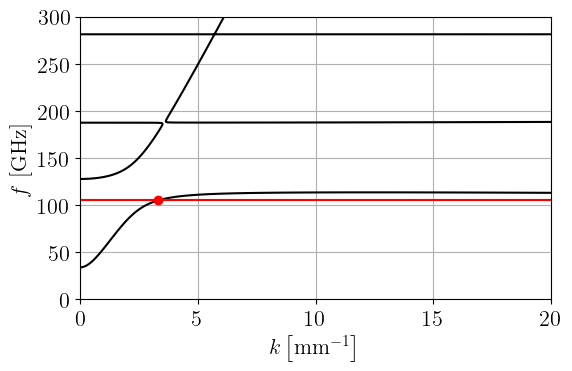

In [315]:
ki = np.linspace(0, 20e3, 1000)
omegai = 2*np.pi*np.linspace(1e-6, 300e9, 1000)
K, O = np.meshgrid(ki, omegai, indexing='ij')
plt.figure(figsize=(6, 4))
plt.contour(K * 1e-3, O/(2*np.pi) * 1e-9, D_vec(x0*np.ones_like(K), K, O), levels=[0], colors=['k'])
plt.plot(k0*1e-3, f0 * 1e-9, 'ro')
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, \mathrm{\left[ mm^{-1} \right]}$')
plt.plot(ki * 1e-3, f0*np.ones_like(ki) * 1e-9, 'r-')
plt.tight_layout()
plt.grid()
plt.show()

#### Plot Density Profile

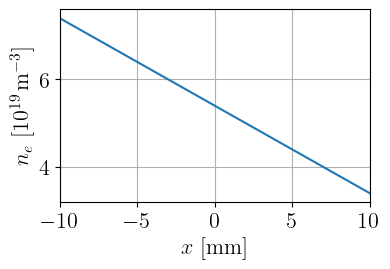

In [316]:
xi = np.linspace(-10e-3, 10e-3, 200)

plt.figure(figsize=(4,2.5))
plt.plot(xi*1e3, n_e(xi)*1e-19)
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(-10, 10)
plt.xlabel('$x$ [mm]')
plt.ylabel(r'$n_e$ [$10^{19} \, \mathrm{m^{-3}}$]')
plt.grid()
plt.show()

#### Plot frequency vs. (simple) UH frequency

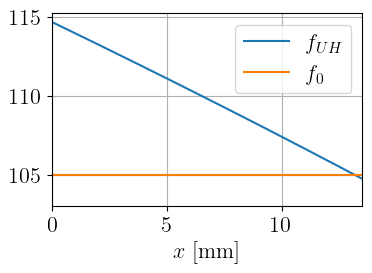

In [317]:
xi = np.linspace(0e-3, 15e-3, 200)

plt.figure(figsize=(4,2.5))
plt.plot(xi*1e3, np.sqrt(omega_c(xi)**2 + omega_p_squared(xi))/(2*np.pi)*1e-9, label=r'$f_{{UH}}$')
plt.plot(xi*1e3, omega0*np.ones_like(xi)/(2*np.pi)*1e-9, label=r'$f_0$')
# plt.plot([0, 16], [omega0*1e-9, omega0*1e-9])
# plt.plot(xi, omega_c(xi)*1e-9)
# plt.plot(xi, np.sqrt(omega_p_squared(xi))*1e-9)
plt.xlim(0, 13.5)
plt.xlabel('$x$ [mm]')
plt.legend()
plt.grid()
plt.show()

#### Trace Ray

In [318]:
max_gauss_quad_order = 3

def get_dispersion_manifold(x0, k0, omega0, nt=5000, ghost_ratio=0.01):
    t, xs, ks, zs, i_start, i_end = trace_ray_1D(x0=x0, k0=k0, omega0=omega0, tmin=0, tmax=30e-9, D=D, x_min = x0, tsteps=nt, ghost_ratio=ghost_ratio, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-10)
    nt = i_end - i_start
    return t, xs, ks, zs, nt, i_start, i_end, x0, k0

def get_mgo_field(phi0, t, zs, i_start, i_end, i_save=[],
                       analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 20}},
                       'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 20}}},):
    branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont, max_gauss_quad_order=max_gauss_quad_order)
    results = mgo_info['saved_results']
    Nt = mgo_info['Nt']
    Upsilon = mgo_info['Upsilon']
    return branch_masks, ray_field, mgo_info, results, Nt, Upsilon

In [319]:
t_orig, xs_orig, ks_orig, zs_orig, nt_orig, i_start_orig, i_end_orig, x0_orig, k0_orig = get_dispersion_manifold(x0, k0, omega0)
S = mgo.get_symplectic_tangent_trfm(zs_orig, t_orig, 1, i_start_orig, i_end_orig)
i_caust = np.argmin(np.abs(S[:, 0, 0]))

In [320]:
i_dt = int(nt_orig/20)
i_save = np.arange(i_caust - i_dt, i_caust + i_dt, 1)

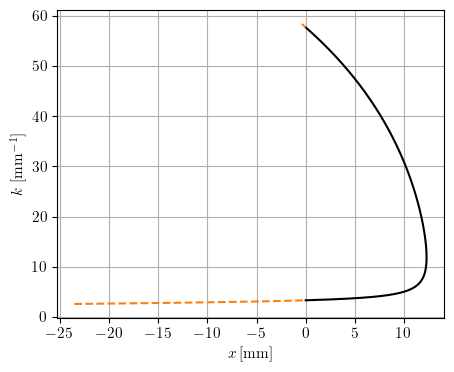

In [295]:
plt.figure(figsize=(5, 4))
plt.plot(xs_orig[i_start_orig:i_end_orig]*1e3, ks[i_start_orig:i_end_orig]*1e-3, color='k')
plt.plot(xs_orig[:i_start_orig]*1e3, ks[:i_start_orig]*1e-3, '--', color='tab:orange')
plt.plot(xs_orig[i_end_orig:]*1e3, ks[i_end_orig:]*1e-3, '--', color='tab:orange')
plt.ylabel(r'$k \,\, [\mathrm{mm^{-1}}]$')
plt.xlabel(r'$x \, [\mathrm{mm}]$')
plt.grid()
plt.show()

#### Check that Local Dispersion Relation is satisfied along ray

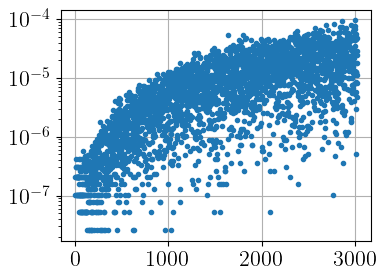

In [321]:
Ds = D_vec(xs_orig, ks_orig, omega0*np.ones_like(xs_orig))

plt.figure(figsize=(4, 3))
plt.plot(np.abs(Ds), '.')
plt.yscale('log')
plt.grid()
plt.show()

## Compare Trace with EPOCH Data and adjust Temperature

Plot Settings:

In [206]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 11

cm = 1/2.54 # 1 cm = 1/2.54 inch

### Load in EPOCH data

In [207]:
epoch_data = np.load('./epoch_data/XBData2.npz')
t_read = 8e-9
argt = np.argmin(np.abs(epoch_data['t'] - t_read))

#### Inspect EPOCH Data

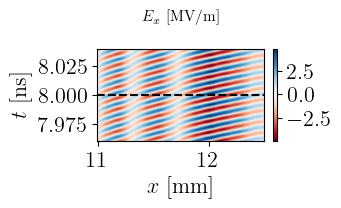

In [369]:
tmin = 7.96e-9
tmax = 8.04e-9
where_t = np.where((epoch_data['t'] >= tmin) & (epoch_data['t'] <= tmax))
fig = plt.figure(constrained_layout=True, figsize=(8.4*cm, 5*cm))

# plt.contourf(epoch_data['x']*1e3, epoch_data['t'][where_t]*1e9, epoch_data['E'][where_t], cmap='RdBu', levels=20)
plt.pcolormesh(epoch_data['x']*1e3, epoch_data['t'][where_t]*1e9, epoch_data['E'][where_t]*1e-6, shading='gouraud', cmap='RdBu')
plt.plot(epoch_data['x']*1e3, t_read*1e9*np.ones_like(epoch_data['x']), 'k--')
# plt.title('Results from Epoch Simulation')
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$t$ [ns]')
plt.title(r'$E_x$ [MV/m]', fontsize=11)
plt.colorbar()
plt.savefig('./plots/XB_epoch_data.png', dpi=300)
plt.show()

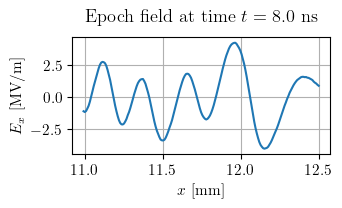

In [209]:
fig = plt.figure(constrained_layout=True, figsize=(8.4*cm, 5*cm))
plt.plot(epoch_data['x']*1e3, epoch_data['E'][argt, :]*1e-6)
plt.grid()
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$E_x$ [MV/m]')
plt.title(r'Epoch field at time $t=' + str(round(epoch_data['t'][argt]*1e9, 2)) + r'$ ns')
plt.show()

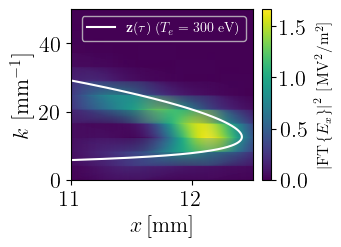

In [373]:
from scipy.signal import stft
nperseg = len(epoch_data['E'][argt, :])/1
noverlap = nperseg - 1
spatial_freq_epoch, xs_epoch, Zxx = stft(epoch_data['E'][argt, :], 1/np.diff(epoch_data['x'])[0], nperseg=nperseg, noverlap=noverlap)
ks_epoch = 2*np.pi*spatial_freq_epoch

fig = plt.figure(constrained_layout=True, figsize=(8.4*cm, 6*cm))
plt.pcolormesh(epoch_data['x'][0]*1e3 + xs_epoch*1e3, ks_epoch*1e-3, np.abs(Zxx)**2*1e-12, shading='gouraud')
plt.plot(xs_orig[i_start_orig:i_end_orig]*1e3, ks_orig[i_start_orig:i_end_orig]*1e-3, color='w', label=r'$\mathbf{z}(\tau) \; (T_e = 300$ eV)')
plt.xlim(epoch_data['x'][0]*1e3, epoch_data['x'][0]*1e3 + np.max(xs_epoch)*1e3)
plt.xlim(7, epoch_data['x'][0]*1e3 + np.max(xs_epoch)*1e3)
plt.ylabel(r'$k \,\, [\mathrm{mm^{-1}}]$')
plt.xlabel(r'$x \, [\mathrm{mm}]$')
plt.xlim(11, 12.5)
plt.ylim(0, 50)
cbar = plt.colorbar()
cbar.set_label(r'$\left| \mathrm{FT} \left \{ E_x \right \} \right|^2$ [$\, \mathrm{{MV}^2/m^2}$]', size=11)
# plt.colorbar()
# plt.title(r'$\left| \mathrm{FT} \left \{ E_x \right \} \right|^2$ [$\, \mathrm{{MV}^2/m^2}$]', fontsize=11)
plt.legend(labelcolor='white', fontsize=10, facecolor='none')
plt.savefig('./plots/XB_epoch_stft.png', dpi=300)
plt.show()

### Find optimal temperature

In [297]:
_x0 = 10.5e-3
_k0 = get_k0(_x0, omega0, 0, 10000)
print('_k0', _k0, ' m^-1')

_nt = len(xs_orig[xs_orig > _x0])
print('_nt', _nt)

_k0 5358.267307021158  m^-1
_nt 885


In [298]:
T0s = np.linspace(1.29-0.1, 1.36+0.1, 21) * 300 * e
T0s/(300*e)

array([1.19  , 1.2035, 1.217 , 1.2305, 1.244 , 1.2575, 1.271 , 1.2845,
       1.298 , 1.3115, 1.325 , 1.3385, 1.352 , 1.3655, 1.379 , 1.3925,
       1.406 , 1.4195, 1.433 , 1.4465, 1.46  ])

In [299]:
ms = []

for i, _T0 in enumerate(T0s):
    T0 = _T0
    print(T0/(300*e), end='\r')
    _ts, _xs, _ks, _zs, __nt, _i_start, _i_end, _x0, _k0 = get_dispersion_manifold(_x0, _k0, omega0, _nt, ghost_ratio=0)
    ms.append(
        {'T0': _T0, 'ts': _ts, 'xs': _xs, 'ks': _ks, 'zs': _zs, 'nt': __nt,
         'i_start': _i_start, 'i_end': _i_end, 'x0': _x0, 'k0': _k0}
    )

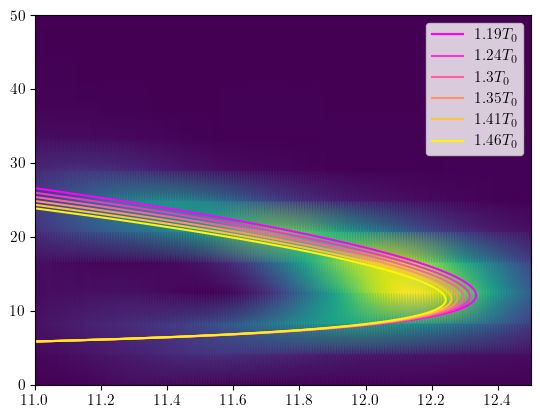

In [300]:
plt.pcolormesh(epoch_data['x'][0]*1e3 + xs_epoch*1e3, ks_epoch*1e-3, np.abs(Zxx)**2*1e-12, shading='gouraud')

cmap = plt.get_cmap('spring')
for i, m in enumerate(ms):
    if i % 4 != 0:
        continue
    _T0, _ts, _xs, _ks, _zs, __nt, _i_start, _i_end, _x0, _k0 = (m[k] for k in ['T0', 'ts', 'xs', 'ks', 'zs', 'nt', 'i_start', 'i_end', 'x0', 'k0'])
    plt.plot(_xs*1e3, _ks*1e-3, '-', color=cmap(i/len(ms)), label=r'' + str(round(_T0/(300*e), 2)) + r'$T_0$')

plt.legend()
plt.xlim(11, 12.5)
plt.ylim(0, 50)
plt.show()

In [346]:
def find_optimal_ampl_and_phase(xi, field, epoch_data, argt, n_phases=1000):
    '''returns A_abs, phase, new_field, err_abs, err_phase'''
    where_xi = np.where((epoch_data['x'] >= np.min(xi)) & (epoch_data['x'] <= np.max(xi)))
    epoch_max = np.max(epoch_data['E'][:, where_xi], axis=0)
    A_abs = np.mean(epoch_max)/np.mean(np.abs(field(xi)))
    field_renorm = lambda x: A_abs * field(x)
    err_abs = np.sum((np.abs(field_renorm(epoch_data['x'][where_xi])) - epoch_max)**2, axis=1)

    phases = np.linspace(0, 2*np.pi, n_phases).reshape(-1, 1)
    phase_factors = np.exp(1j*phases)
    fields_with_phases = (phase_factors @ field_renorm(epoch_data['x'][where_xi]).reshape(1, -1))
    error_phases = np.sum((np.real(fields_with_phases) - epoch_data['E'][argt, where_xi])**2, axis=1)

    arg_phase = np.argmin(error_phases)
    phase = phases[arg_phase]
    new_field = lambda x: phase_factors[arg_phase]*field_renorm(x)
    err_phase = error_phases[arg_phase]
    return A_abs, phase, new_field, err_abs, err_phase

GOs = []
phi0 = 1

for m in ms:
    _T0, _ts, _xs, _ks, _zs, __nt, _i_start, _i_end, _x0, _k0 = (m[k] for k in ['T0', 'ts', 'xs', 'ks', 'zs', 'nt', 'i_start', 'i_end', 'x0', 'k0'])
    _go_branch_masks, _go_ray_field = mgo.get_go_field_1D(_ts, _zs, phi0, _i_start, _i_end)
    _go_field = mgo.superpose_ray_fields(phi0=phi0, x0=_x0+1e-3, xs=_xs, branch_masks=_go_branch_masks, ray_field=_go_ray_field, i_start=_i_start, i_end=_i_end, interpolation_method='linear')

    xi_amp = np.linspace(11e-3, 11.5e-3, 1000)
    _A_abs, _phase, _new_field, _err_abs, _err_phase = find_optimal_ampl_and_phase(xi_amp, _go_field, epoch_data, argt)
    GOs.append(
        {'branch_masks': _go_branch_masks, 'ray_field': _go_ray_field, 'old_field': _go_field,
         'A_abs': _A_abs, 'phase': '_phase', 'new_field': _new_field, 'err_abs': _err_abs, 'err_phase': _err_phase
         }
    )

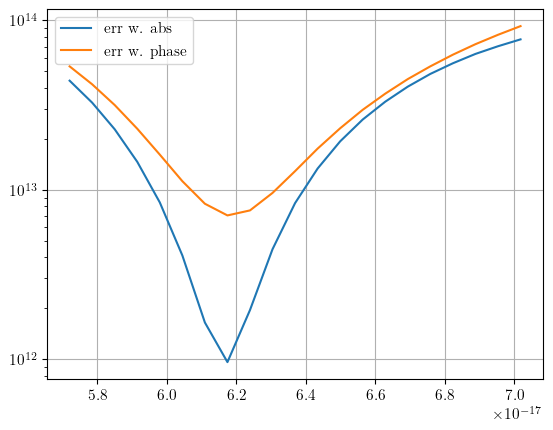

In [302]:
plt.plot(T0s, [GO['err_abs'] for GO in GOs], label='err w. abs')
plt.plot(T0s, [GO['err_phase'] for GO in GOs], label='err w. phase')
plt.gca().set_yscale('log')
plt.grid()
plt.legend()
plt.show()

In [303]:
print(np.argmin([GO['err_phase'] for GO in GOs]),  np.argmin([GO['err_abs'] for GO in GOs]))
arg_best_T = np.argmin([GO['err_abs'] for GO in GOs])
print('arg_best_T:', arg_best_T)
print('optimal temperature is', np.round(T0s[arg_best_T] / (300*e), 3), ' T0 = ', np.round(T0s[arg_best_T]/e), ' eV')

7 7
arg_best_T: 7
optimal temperature is 1.284  T0 =  385.0  eV


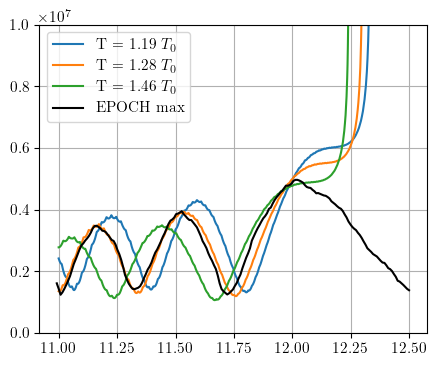

In [304]:
xi = np.linspace(11e-3, 12.4e-3, 1000)

plt.figure(figsize=(5, 4))
ind = [0, arg_best_T, -1]
for m, GO in zip([ms[i] for i in ind], [GOs[i] for i in ind]):
    T0 = m['T0']
    _A_abs, _phase, _new_field, _err_abs = (GO[k] for k in ['A_abs', 'phase', 'new_field', 'err_abs'])
    plt.plot(xi*1e3, np.abs(_new_field(xi)), label='T = ' + str(round(T0/(300*e), 2)) + ' $T_0$')
plt.plot(epoch_data['x']*1e3, np.max(epoch_data['E'], axis=0), 'k-', label='EPOCH max')
plt.legend()
plt.ylim(0, 1e7)
plt.grid()
plt.show()

#### Trace with optimal Temperature

In [325]:
T0 = T0s[arg_best_T]

t, xs, ks, zs, nt, i_start, i_end, x0, k0 = get_dispersion_manifold(x0, k0, omega0)
S = mgo.get_symplectic_tangent_trfm(zs, t, 1, i_start, i_end)
i_caust = np.argmin(np.abs(S[:, 0, 0]))

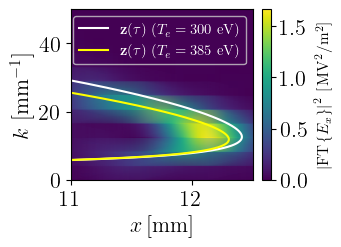

In [376]:
fig = plt.figure(constrained_layout=True, figsize=(8.4*cm, 6*cm))
plt.pcolormesh(epoch_data['x'][0]*1e3 + xs_epoch*1e3, ks_epoch*1e-3, np.abs(Zxx)**2*1e-12, shading='gouraud')
plt.plot(xs_orig[i_start_orig:i_end_orig]*1e3, ks_orig[i_start_orig:i_end_orig]*1e-3, color='w',
         label=r'$\mathbf{z}(\tau) \; (T_e = 300$ eV)')
plt.plot(xs[i_start:i_end]*1e3, ks[i_start:i_end]*1e-3, color='yellow',
         label=r'$\mathbf{z}(\tau) \; (T_e = ' + str(int(T0/e)) + '$ eV)')
plt.xlim(epoch_data['x'][0]*1e3, epoch_data['x'][0]*1e3 + np.max(xs_epoch)*1e3)
plt.xlim(7, epoch_data['x'][0]*1e3 + np.max(xs_epoch)*1e3)
plt.ylabel(r'$k \,\, [\mathrm{mm^{-1}}]$')
plt.xlabel(r'$x \, [\mathrm{mm}]$')
plt.xlim(11, 12.5)
plt.ylim(0, 50)
cbar = plt.colorbar()
cbar.set_label(r'$\left| \mathrm{FT} \left \{ E_x \right \} \right|^2$ [$\, \mathrm{{MV}^2/m^2}$]', size=11)
# plt.colorbar()
# plt.title(r'$\left| \mathrm{FT} \left \{ E_x \right \} \right|^2$ [$\, \mathrm{{MV}^2/m^2}$]', fontsize=11)
plt.legend(labelcolor='white', fontsize=10.5, facecolor='none')
plt.savefig('./plots/XB_epoch_stft_with_traces.png', dpi=300)
plt.show()

## MGO and GO Field Construction

### Find MGO and GO fields

Find MGO and GO Fields with 1 as initial amplitude

In [341]:
phi0 = 1
analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 10}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 10}}}
mgo_branch_masks, mgo_ray_field, info, results, Nt, Upsilon = get_mgo_field(phi0, t, zs, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont)

In [396]:
mgo_A0, _ = mgo.get_A0_and_interpolation(phi0, x0+1e-3, xs, i_start, i_end, mgo_branch_masks, mgo_ray_field, interpolation_method='linear')
mgo_field = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-3, xs=xs, branch_masks=mgo_branch_masks, ray_field=mgo_ray_field, i_start=i_start, i_end=i_end, interpolation_method='linear')

In [397]:
go_branch_masks, go_ray_field = mgo.get_go_field_1D(t, zs, phi0, i_start, i_end)
go_A0, _ = mgo.get_A0_and_interpolation(phi0, x0+1e-3, xs, i_start, i_end, go_branch_masks, go_ray_field, interpolation_method='linear')
go_field = mgo.superpose_ray_fields(phi0=phi0, x0=x0+1e-3, xs=xs, branch_masks=go_branch_masks, ray_field=go_ray_field, i_start=i_start, i_end=i_end, interpolation_method='linear')

#### Find optimal amplitude and phase to match EPOCH simulation

In [348]:
xi_amp = np.linspace(11e-3, 11.5e-3, 1000)
A_abs, phase, _, _, _ = find_optimal_ampl_and_phase(xi_amp, mgo_field, epoch_data, argt)

mgo_new_field = lambda x: A_abs*np.exp(1j*phase) * mgo_field(x)
go_new_field = lambda x: A_abs*np.exp(1j*phase) * go_field(x)

#### Plot Ingoing and Outgoing MGO Field

In [402]:
xi_amp = np.linspace(11e-3, 11.5e-3, 1000)

go_A = A_abs*np.exp(1j*phase) * go_A0
mgo_A = A_abs*np.exp(1j*phase) * mgo_A0

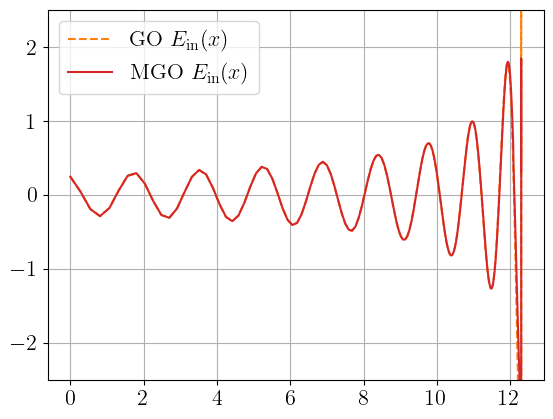

In [403]:
plt.plot(xs[i_start:i_start+i_caust]*1e3, 1e-6*np.real(go_A * go_ray_field[:i_caust]), '--', color='tab:orange', label=r'GO $E_{\mathrm{in}}(x)$')
plt.plot(xs[i_start:i_start+i_caust]*1e3, 1e-6*np.real(mgo_A * mgo_ray_field[:i_caust]), '-', color='tab:red', label=r'MGO $E_{\mathrm{in}}(x)$')
plt.legend()
plt.ylim(-2.5, 2.5)
plt.grid()
plt.show()

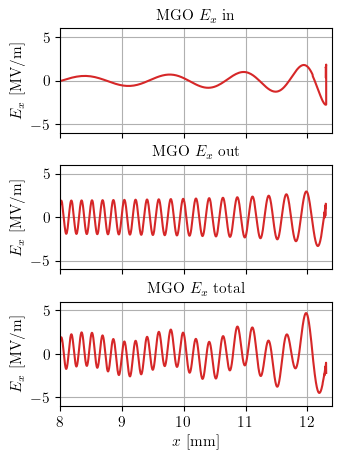

In [460]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 11
rcParams['axes.titlepad'] = 6

nrows = 3
# fig = plt.figure(constrained_layout=True, figsize=(8.4*cm, 6*nrows*cm))

fig, ax = plt.subplots(nrows, 1, constrained_layout=True, figsize=(8.4*cm, 3.8*nrows*cm))
# ax[0].plot(xs[i_start:i_start+i_caust]*1e3, 1e-6*np.real(go_A * go_ray_field[:i_caust]), '--', color='tab:orange', label=r'GO $E_{x}$ in')
# ax[0].plot(xs[i_start:i_start+i_caust]*1e3, 1e-6*np.real(mgo_A * mgo_ray_field[:i_caust]), '-', color='tab:red', label=r'MGO $E_{x}$ in')
# ax[0].legend(loc='upper left')
ax[0].plot(xs[i_start:i_start+i_caust]*1e3, 1e-6*np.real(mgo_A * mgo_ray_field[:i_caust]), '-', color='tab:red')
ax[0].set_title(r'MGO $E_{x}$ in', fontsize=11)
ax[0].grid()
ax[0].sharex(ax[2])
ax[0].tick_params('x', labelbottom=False)
ax[0].set_ylim(-6, 6)
ax[0].set_ylabel(r'$E_x$ [MV/m]')

# ax[1].plot(xs[i_start+i_caust:i_end]*1e3, 1e-6*np.real(go_A * go_ray_field[i_caust:]), '--', color='tab:orange', label=r'GO $E_{x}$ out')
# ax[1].plot(xs[i_start+i_caust:i_end]*1e3, 1e-6*np.real(mgo_A * mgo_ray_field[i_caust:]), '-', color='tab:red', label=r'MGO $E_{x}$ out')
# ax[1].legend(loc='upper left')
ax[1].plot(xs[i_start+i_caust:i_end]*1e3, 1e-6*np.real(mgo_A * mgo_ray_field[i_caust:]), '-', color='tab:red')
ax[1].set_title(r'MGO $E_{x}$ out', fontsize=11)
ax[1].grid()
ax[1].sharex(ax[2])
ax[1].tick_params('x', labelbottom=False)
ax[1].set_ylim(-6, 6)
ax[1].set_ylabel(r'$E_x$ [MV/m]')

xi = np.linspace(np.min(xs[i_start:i_end]), np.max(xs[i_start:i_end]), 6000)
# ax[2].plot(xi*1e3, 1e-6*np.real(go_new_field(xi)), '--', color='tab:orange', label=r'GO $E_{x}$ tot')
# ax[2].plot(xi*1e3, 1e-6*np.real(mgo_new_field(xi)), '-', color='tab:red', label=r'MGO $E_{x}$ tot')
# ax[2].legend(loc='upper left')
ax[2].plot(xi*1e3, 1e-6*np.real(mgo_new_field(xi)), '-', color='tab:red')
ax[2].set_title(r'MGO $E_{x}$ total', fontsize=11)
ax[2].grid()
ax[1].set_xlim(8, np.max(xs)*1e3+0.1)
ax[2].set_ylim(-6, 6)
ax[2].set_xlabel(r'$x$ [mm]')
ax[2].set_ylabel(r'$E_x$ [MV/m]')

plt.savefig('./plots/XB_mgo_in_and_out.pdf')
plt.savefig('./plots/XB_mgo_in_and_out.png', dpi=300)
plt.show()

#### Plot MGO and GO fields with EPOCH solution

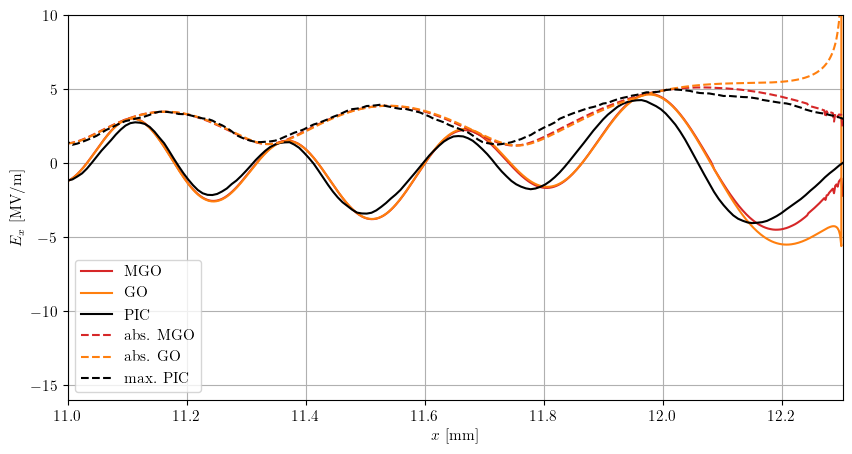

In [462]:
xi = np.linspace(0, np.max(xs), 6000)

plt.figure(figsize=(10, 5))
plt.plot(xi*1e3, np.real(mgo_new_field(xi))*1e-6, '-', color='tab:red', label='MGO')
plt.plot(xi*1e3, np.real(go_new_field(xi))*1e-6, '-', color='tab:orange', label='GO')
plt.plot(epoch_data['x']*1e3, epoch_data['E'][argt]*1e-6, '-', color='k', label='PIC')

plt.plot(xi*1e3, np.abs(mgo_new_field(xi))*1e-6, '--', color='tab:red', label='abs. MGO')
plt.plot(xi*1e3, np.abs(go_new_field(xi))*1e-6, '--', color='tab:orange', label='abs. GO')
plt.plot(epoch_data['x']*1e3, np.max(epoch_data['E'], axis=0)*1e-6, '--', color='k', label='max. PIC')

plt.grid()
plt.legend()
plt.xlim(11, np.max(xs)*1e3)
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$E_x$ [MV/m]')
plt.ylim(-16, 10)
plt.savefig('./plots/XB_mgo.pdf')
plt.savefig('./plots/XB_mgo.png', dpi=300)
plt.show()

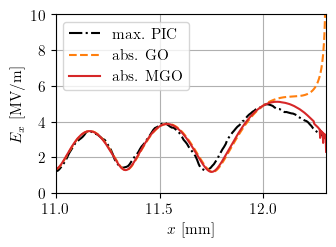

In [465]:
xi = np.linspace(0, np.max(xs), 6000)

fig = plt.figure(constrained_layout=True, figsize=(8.4*cm, 6*cm))
plt.plot(epoch_data['x']*1e3, np.max(epoch_data['E'], axis=0)*1e-6, '-.', color='k', label='max. PIC')
plt.plot(xi*1e3, np.abs(go_new_field(xi))*1e-6, '--', color='tab:orange', label='abs. GO')
plt.plot(xi*1e3, np.abs(mgo_new_field(xi))*1e-6, '-', color='tab:red', label='abs. MGO')

plt.grid()
plt.legend()
plt.xlim(11, np.max(xs)*1e3)
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$E_x$ [MV/m]')
plt.ylim(0, 10)
plt.savefig('./plots/XB_mgo_abs.pdf')
plt.savefig('./plots/XB_mgo_abs.png', dpi=300)
plt.show()

In [468]:
np.min(epoch_data['t'])*1e9, np.max(epoch_data['t'])*1e9, (np.max(epoch_data['t']) - np.min(epoch_data['t']))*1e9

(6.500238805355162, 11.999085861424414, 5.498847056069252)